d-sandbox

<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="https://media.geeksforgeeks.org/wp-content/uploads/merge3cluster.jpg" alt="Clustering" style="width: 600px">
</div>

# Comparing K-Means clustering in scikit-learn vs. sparkML

In this notebook, we will use  iris dataset as an example.

## ![Spark Logo Tiny](https://files.training.databricks.com/images/105/logo_spark_tiny.png) We will see:<br>
 - sklearn.cluster 
 - pyspark.ml.clustering 
 - compare SSE and silhouette

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Scikit_learn_logo_small.svg/1200px-Scikit_learn_logo_small.svg.png" alt="scikit learn" width="200"/>  

First, let's see sklearn

In [0]:
import numpy as np
import pandas as pd


# load iris dataset

from sklearn import datasets
iris = datasets.load_iris()


x = iris.data  # 4 numerical variables (sepal length, sepal width, petal length, petal width)


# target will not be used in the analysis since we are doing clustering
y = iris.target # target variable (0:Setosa, 1:Versicolour, 2:Virginica)

# check first 6 rows 
print('No. of rows in the data: ',len(x))
print('This is first 6 rows: ')
x[0:6:]

No. of rows in the data: 150
This is first 6 rows: 
Out[275]: array([[5.1, 3.5, 1.4, 0.2],
 [4.9, 3. , 1.4, 0.2],
 [4.7, 3.2, 1.3, 0.2],
 [4.6, 3.1, 1.5, 0.2],
 [5. , 3.6, 1.4, 0.2],
 [5.4, 3.9, 1.7, 0.4]])

In [0]:
# convert nan to 0 if any
X = np.nan_to_num(x)

# standardization 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
x_scaled = scaler.transform(X)


In [0]:
# scikit-learn K-Means clustering 

scikit_SSE = []  
scikit_ss = []

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

for no_cluster in range(2,16):
    kmeans = KMeans(n_clusters = no_cluster, init = 'random', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x_scaled)
    scikit_SSE.append(kmeans.inertia_)   
    
    y_kmeans = kmeans.fit_predict(x_scaled)
    silhouette = silhouette_score(x_scaled, y_kmeans)
    scikit_ss.append(silhouette)

Out[278]:

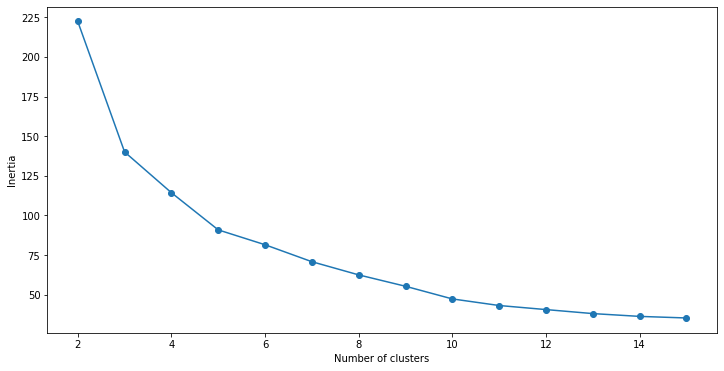

Text(0, 0.5, 'Inertia')

In [0]:
# Elbow method by SSE

import matplotlib.pyplot as plt


plt.figure(figsize=(12,6))
plt.plot(range(2,16), scikit_SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')   # Sum of squared distances of samples to their closest cluster center

Out[279]:

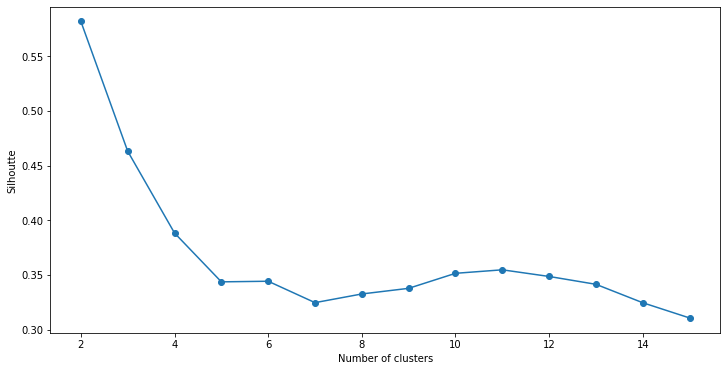

Text(0, 0.5, 'Silhoutte')

In [0]:
# Elbow method by silhouette score (measure of how close each point in one cluster is to points in the neighboring clusters)


plt.figure(figsize=(12,6))
plt.plot(range(2, 16), scikit_ss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte')  # near +1 indicate that the sample is far away from the neighboring clusters


Out[280]:

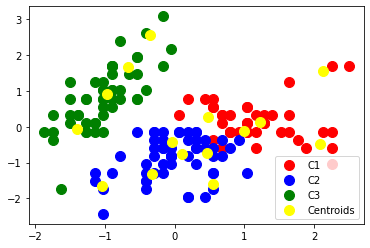

<matplotlib.legend.Legend at 0x7f58958738b0>

In [0]:
# Assume optimal No. of cluster as 3 and re-run K-means

scikit_kmeans = KMeans(n_clusters = 3, init = 'random', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = scikit_kmeans.fit_predict(x_scaled)

plt.scatter(x_scaled[y_kmeans == 0, 0], x_scaled[y_kmeans == 0, 1], s = 100, c = 'red', label = 'C1')
plt.scatter(x_scaled[y_kmeans == 1, 0], x_scaled[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'C2')
plt.scatter(x_scaled[y_kmeans == 2, 0], x_scaled[y_kmeans == 2, 1], s = 100, c = 'green', label = 'C3')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 100, c = 'yellow', label = 'Centroids')
plt.legend()

In [0]:
# observe mean value of each attribute
pd.concat([pd.DataFrame(x) , pd.DataFrame({'labels':y_kmeans})], axis=1).groupby(["labels"]).mean()

Out[281]:

,0,1,2,3
labels,,,,
0,6.806818,3.120455,5.522727,1.981818
1,5.833929,2.676786,4.421429,1.435714
2,5.006000,3.428000,1.462000,0.246000


In [0]:
pd.concat([pd.DataFrame(x[:,:1]), pd.DataFrame({'Actual_group':y}) , pd.DataFrame({'labels':y_kmeans})], axis=1).groupby(["labels","Actual_group"]).count()

Out[282]:

0 
 
 
 labels 
 Actual_group 
 
 
 
 
 
 0 
 1 
 11 
 
 
 2 
 33 
 
 
 1 
 1 
 39 
 
 
 2 
 17 
 
 
 2 
 0 
 50

<img src="https://miro.medium.com/max/1400/0*Qm6kqcD9iTOcTj-Z.png" alt="sparkml" width="250"/>  

Then, let's see pyspark.ml

In [0]:
# convert numpy array to spark dataframe

X_df = pd.DataFrame(X)
X_sdf = spark.createDataFrame(X_df)

In [0]:
# vector assemble 
from pyspark.ml.feature import VectorAssembler

assemble = VectorAssembler(inputCols = X_sdf.columns, outputCol = 'features')
assembled_sdf = assemble.transform(X_sdf)

In [0]:
# standardization 
from pyspark.ml.feature import StandardScaler
scale = StandardScaler(inputCol='features', outputCol = 'standardized')
sdf_scale = scale.fit(assembled_sdf).transform(assembled_sdf)


In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

spark_SSE = []
spark_ss=[]

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', metricName='silhouette', distanceMeasure='squaredEuclidean')

for no_cluster in range(2,16):
  
  kmeans = KMeans(featuresCol = 'standardized', k = no_cluster)
  model = kmeans.fit(sdf_scale)
  cost = model.summary.trainingCost  # computeCost is deprecated and removed in 3.0.0 
  spark_SSE.append(cost)    
   
  KMeans_fit = kmeans.fit(sdf_scale).transform(sdf_scale)
  score = evaluator.evaluate(KMeans_fit)
  spark_ss.append(score)
   
 
  

Out[287]:

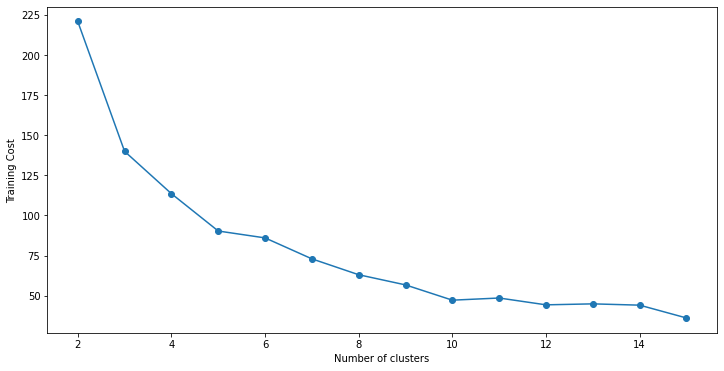

Text(0, 0.5, 'Training Cost')

In [0]:
# Elbow method by SSE

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(range(2,16), spark_SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Training Cost')   # Sum of squared distances to the nearest centroid for all points in the training dataset. This is equivalent to sklearn's inertia

Out[288]:

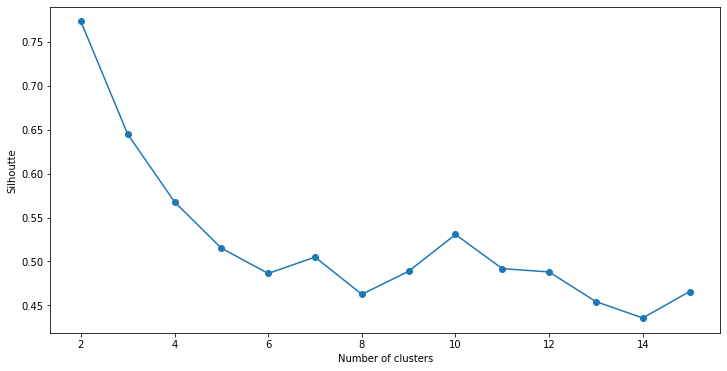

Text(0, 0.5, 'Silhoutte')

In [0]:
# Elbow method by silhouette score (measure of how close each point in one cluster is to points in the neighboring clusters)

plt.figure(figsize=(12,6))
plt.plot(range(2, 16), spark_ss,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte')  # near +1 indicate that the sample is far away from the neighboring clusters

In [0]:
# Assume optimal No. of cluster as 3 and re-run K-means

from pyspark.ml.clustering import KMeans
spark_kmeans = KMeans(featuresCol = 'standardized', k = 3)
model = spark_kmeans.fit(sdf_scale)
spark_kmeans = model.transform(sdf_scale)


y_kmeans_array = np.array(spark_kmeans.select('prediction').collect())
y_kmeans_array = y_kmeans_array.reshape(150, )
y_kmeans_array

Out[289]: array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0,
 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2,
 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0])

Out[290]:

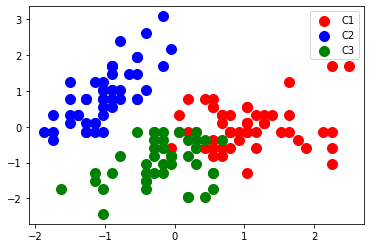

<matplotlib.legend.Legend at 0x7f5895766d30>

In [0]:
plt.scatter(x_scaled[y_kmeans_array == 0, 0], x_scaled[y_kmeans_array == 0, 1], s = 100, c = 'red', label = 'C1')
plt.scatter(x_scaled[y_kmeans_array == 1, 0], x_scaled[y_kmeans_array == 1, 1], s = 100, c = 'blue', label = 'C2')
plt.scatter(x_scaled[y_kmeans_array == 2, 0], x_scaled[y_kmeans_array == 2, 1], s = 100, c = 'green', label = 'C3')

#plt.scatter(pd.DataFrame(model.clusterCenters())[0], pd.DataFrame(model.clusterCenters())[1], s = 100, c = 'yellow', label = 'Centroids')  # can't use clusterCenters here as it is not scaled.
plt.legend()

In [0]:
# observe mean value of each attribute
pd.concat([pd.DataFrame(x) , pd.DataFrame({'labels':y_kmeans_array})], axis=1).groupby(["labels"]).mean()

Out[291]:

,0,1,2,3
labels,,,,
0,6.696364,3.060000,5.418182,1.938182
1,5.016327,3.451020,1.465306,0.244898
2,5.704348,2.634783,4.215217,1.332609


#### Compare scikit-learn and sparkML 'SSE' and 'Silhoutte'
- SSE of scikit and sparkML are very closed
- sparkML's silhoutte is larger as Spark uses an the squared euclidean as the distance measure as compared to sklearn that uses normal euclidean distance by default. More details can be found at this <a href="https://stackoverflow.com/questions/60860415/different-silhouette-scores-when-using-sklearn-and-spark">link</a>.

Out[292]:

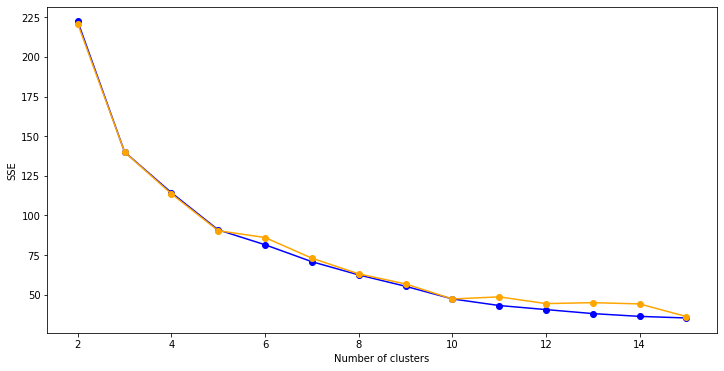

Text(0, 0.5, 'SSE')

In [0]:
plt.figure(figsize=(12,6))
plt.plot(range(2,16), scikit_SSE, marker='o', color ='blue')
plt.plot(range(2,16), spark_SSE, marker='o', color ='orange')
plt.xlabel('Number of clusters')
plt.ylabel('SSE') 


No handles with labels found to put in legend.
Out[293]:

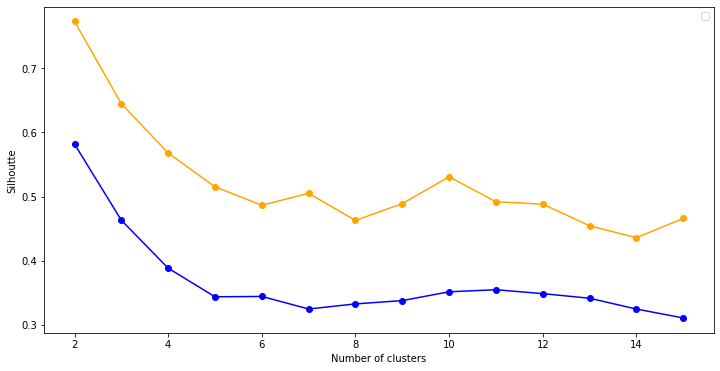

<matplotlib.legend.Legend at 0x7f58956983a0>

In [0]:
plt.figure(figsize=(12,6))
plt.plot(range(2,16), scikit_ss, marker='o', color ='blue')
plt.plot(range(2,16), spark_ss, marker='o', color ='orange')
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte') 
plt.legend()

Out[296]:

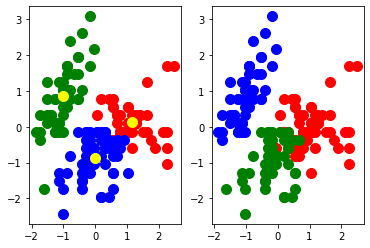

<matplotlib.collections.PathCollection at 0x7f58954f4c40>

In [0]:
plt.subplot(1, 2, 1)
plt.scatter(x_scaled[y_kmeans == 0, 0], x_scaled[y_kmeans == 0, 1], s = 100, c = 'red', label = 'C1')
plt.scatter(x_scaled[y_kmeans == 1, 0], x_scaled[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'C2')
plt.scatter(x_scaled[y_kmeans == 2, 0], x_scaled[y_kmeans == 2, 1], s = 100, c = 'green', label = 'C3')
plt.scatter(scikit_kmeans.cluster_centers_[:, 0], scikit_kmeans.cluster_centers_[:,1], s = 100, c = 'yellow', label = 'Centroids')


plt.subplot(1, 2, 2)
plt.scatter(x_scaled[y_kmeans_array == 0, 0], x_scaled[y_kmeans_array == 0, 1], s = 100, c = 'red', label = 'C1')
plt.scatter(x_scaled[y_kmeans_array == 1, 0], x_scaled[y_kmeans_array == 1, 1], s = 100, c = 'blue', label = 'C2')
plt.scatter(x_scaled[y_kmeans_array == 2, 0], x_scaled[y_kmeans_array == 2, 1], s = 100, c = 'green', label = 'C3')
